In [58]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from seqeval.metrics import classification_report as seqeval_report
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import re, dateparser
from IPython.display import display, HTML
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [22]:
DATA_PATH_TRAIN = "C:/Users/harsh/Downloads/ner_legal/data/NER_TRAIN/NER_TRAIN_JUDGEMENT.json"
DATA_PATH_DEV = "C:/Users/harsh/Downloads/ner_legal/data/NER_DEV/NER_DEV_JUDGEMENT.json"

In [23]:
with open(DATA_PATH_TRAIN) as f:
    train_data = json.load(f)
with open(DATA_PATH_DEV) as f:
    dev_data = json.load(f)

In [24]:
def to_bio_format(dataset):
    tokenized_sentences = []
    label_sentences = []

    for item in dataset:
        text = item["data"]["text"]
        tokens = word_tokenize(text)

        labels = ["O"] * len(tokens)

        if "annotations" in item and len(item["annotations"]) > 0:
            for ent in item["annotations"][0]["result"]:
                ent_text = ent["value"]["text"]
                ent_label = ent["value"]["labels"][0] 

                ent_tokens = word_tokenize(ent_text)

                for i in range(len(tokens)):
                    if tokens[i:i+len(ent_tokens)] == ent_tokens:
                        labels[i] = "B-" + ent_label
                        for j in range(1, len(ent_tokens)):
                            labels[i+j] = "I-" + ent_label
                        break  

        tokenized_sentences.append(tokens)
        label_sentences.append(labels)

    return tokenized_sentences, label_sentences

train_tokens, train_labels = to_bio_format(train_data)
dev_tokens, dev_labels = to_bio_format(dev_data)

print(train_tokens[0])
print(train_labels[0])

['(', '7', ')', 'On', 'specific', 'query', 'by', 'the', 'Bench', 'about', 'an', 'entry', 'of', 'Rs', '.', '1,31,37,500', 'on', 'deposit', 'side', 'of', 'Hongkong', 'Bank', 'account', 'of', 'which', 'a', 'photo', 'copy', 'is', 'appearing', 'at', 'p.', '40', 'of', 'assessee', "'s", 'paper', 'book', ',', 'learned', 'authorised', 'representative', 'submitted', 'that', 'it', 'was', 'related', 'to', 'loan', 'from', 'broker', ',', 'Rahul', '&', 'Co.', 'on', 'the', 'basis', 'of', 'his', 'submission', 'a', 'necessary', 'mark', 'is', 'put', 'by', 'us', 'on', 'that', 'photo', 'copy', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [25]:
word_vocab = {w for sent in train_tokens+dev_tokens for w in sent}
tag_vocab = {t for tags in train_labels+dev_labels for t in tags}

In [26]:
word2idx = {w: i+2 for i, w in enumerate(word_vocab)}
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1
idx2word = {i: w for w, i in word2idx.items()}

In [27]:
tag2idx = {t: i for i, t in enumerate(tag_vocab)}
idx2tag = {i: t for t, i in tag2idx.items()}

In [28]:
MAX_LEN = 128

In [29]:
def encode_sentence(tokens, labels):
    ids = [word2idx.get(w, word2idx["<UNK>"]) for w in tokens]
    tag_ids = [tag2idx[t] for t in labels]
    # pad
    ids = ids[:MAX_LEN] + [word2idx["<PAD>"]] * (MAX_LEN - len(ids))
    tag_ids = tag_ids[:MAX_LEN] + [tag2idx["O"]] * (MAX_LEN - len(tag_ids))
    return ids, tag_ids

In [30]:
X_train = [encode_sentence(x, y)[0] for x, y in zip(train_tokens, train_labels)]
y_train = [encode_sentence(x, y)[1] for x, y in zip(train_tokens, train_labels)]
X_dev = [encode_sentence(x, y)[0] for x, y in zip(dev_tokens, dev_labels)]
y_dev = [encode_sentence(x, y)[1] for x, y in zip(dev_tokens, dev_labels)]

In [31]:
X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_dev, y_dev = torch.tensor(X_dev), torch.tensor(y_dev)

In [32]:
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(NERDataset(X_train, y_train), batch_size=32, shuffle=True)
dev_loader = DataLoader(NERDataset(X_dev, y_dev), batch_size=32)

In [33]:
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=100, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim//2, num_layers=1, 
                            bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        logits = self.fc(lstm_out)
        return logits

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTM_NER(len(word2idx), len(tag2idx)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=tag2idx["O"])

In [35]:
for epoch in range(20):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        loss = criterion(logits.view(-1, len(tag2idx)), y_batch.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f}")

Epoch 1: Loss=1.5680
Epoch 2: Loss=0.8125
Epoch 3: Loss=0.5572
Epoch 4: Loss=0.3908
Epoch 5: Loss=0.2735


In [36]:
model.eval()
y_true, y_pred = [], []

In [37]:
with torch.no_grad():
    for X_batch, y_batch in dev_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=-1)
        for p, y in zip(preds, y_batch):
            p_tags = [idx2tag[i.item()] for i in p if i.item() in idx2tag]
            y_tags = [idx2tag[i.item()] for i in y if i.item() in idx2tag]
            length = min(len(y_tags), len(p_tags))
            y_pred.append(p_tags[:length])
            y_true.append(y_tags[:length])

In [38]:
print(seqeval_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

 CASE_NUMBER     0.0112    0.1250    0.0206       120
       COURT     0.0630    0.3450    0.1066       171
        DATE     0.0179    0.4673    0.0344       214
         GPE     0.0300    0.4878    0.0566       164
       JUDGE     0.0060    0.1429    0.0115         7
         ORG     0.0025    0.1250    0.0050       144
OTHER_PERSON     0.0132    0.2568    0.0250       257
  PETITIONER     0.0000    0.0000    0.0000         9
   PRECEDENT     0.0040    0.0238    0.0068       168
   PROVISION     0.0113    0.0776    0.0198       245
  RESPONDENT     0.0000    0.0000    0.0000         2
     STATUTE     0.0181    0.0936    0.0303       203
     WITNESS     0.0079    0.1765    0.0152        51

   micro avg     0.0090    0.2222    0.0172      1755
   macro avg     0.0142    0.1786    0.0255      1755
weighted avg     0.0183    0.2222    0.0328      1755



In [39]:
flat_true = [tag for sent in y_true for tag in sent]
flat_pred = [tag for sent in y_pred for tag in sent]

In [40]:
cm_data = pd.crosstab(pd.Series(flat_true, name="Actual"),
                      pd.Series(flat_pred, name="Predicted"))

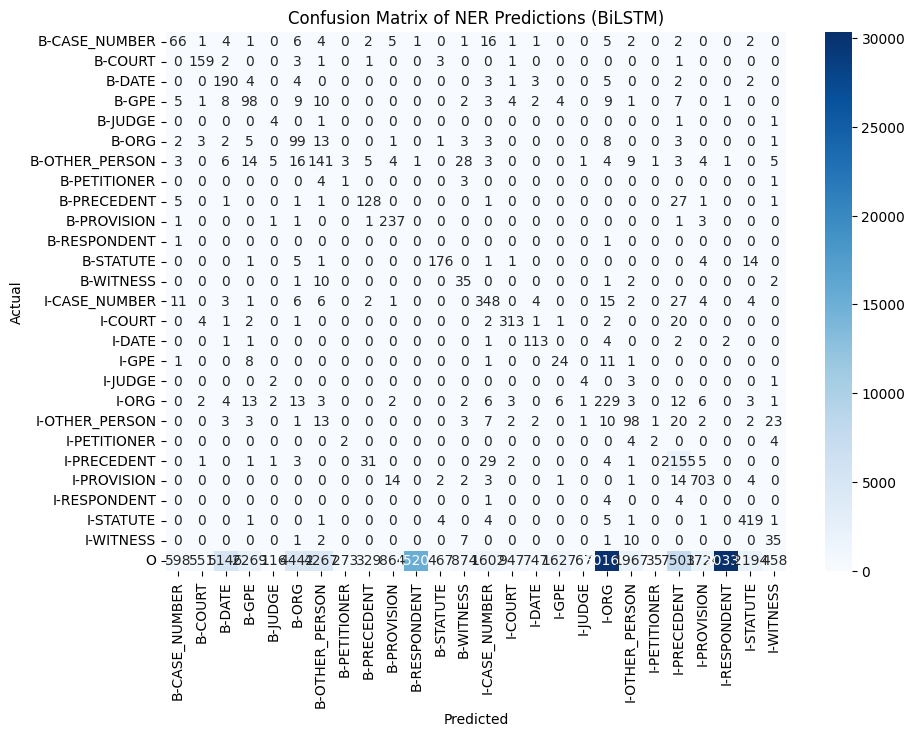

In [41]:
plt.figure(figsize=(10,7))
sns.heatmap(cm_data, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of NER Predictions (BiLSTM)")
plt.show()

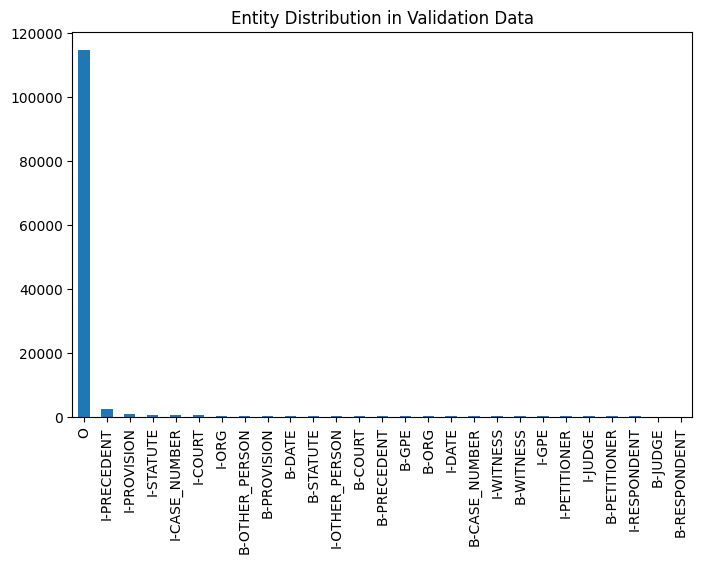

In [42]:
plt.figure(figsize=(8,5))
pd.Series(flat_true).value_counts().plot(kind="bar")
plt.title("Entity Distribution in Validation Data")
plt.show()

In [43]:
def predict(text, model, max_len=MAX_LEN):
    tokens = word_tokenize(text)
    ids = [word2idx.get(w, word2idx["<UNK>"]) for w in tokens]
    ids = ids[:max_len] + [word2idx["<PAD>"]] * (max_len - len(ids))
    ids = torch.tensor(ids).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(ids)
        preds = torch.argmax(logits, dim=-1).squeeze(0).tolist()

    pred_labels = [idx2tag[p] for p in preds[:len(tokens)]]
    return list(zip(tokens, pred_labels))

In [49]:
def rule_based_extraction(text):
    cases = re.findall(r"[A-Z][a-zA-Z]+ v\. [A-Z][a-zA-Z]+", text)
    statutes = re.findall(r"Section\s+\d+[A-Za-z]*", text)
    dates = re.findall(r"\b\d{1,2}\s+[A-Za-z]+\s+\d{4}\b", text)

    results = []
    for c in cases:
        results.append((c, "CASE"))
    for s in statutes:
        results.append((s, "STATUTE"))
    for d in dates:
        results.append((d, "DATE"))
    return results

In [51]:
def hybrid_visualize(text, model):
    preds = predict(text, model)   # ML predictions
    rules = rule_based_extraction(text)  # Rule-based

    rule_dict = {}
    for phrase, label in rules:
        for tok in phrase.split():
            rule_dict[tok] = label

    color_map = {
        "ORG": "#a6cee3",
        "LOC": "#b2df8a",
        "CASE": "#fb9a99",
        "STATUTE": "#fdbf6f",
        "DATE": "#cab2d6"
    }

    html = "<div style='font-size:16px; line-height:1.8;'>"
    for token, ml_label in preds:
        label = ml_label
        if label == "O" and token in rule_dict: 
            label = rule_dict[token]

        if label != "O":
            ent_type = label.split("-")[-1]
            color = color_map.get(ent_type, "#ffff99")
            html += f"<span style='background-color:{color}; padding:2px 4px; border-radius:4px;'>{token} <sub>{ent_type}</sub></span> "
        else:
            html += token + " "
    html += "</div>"

    display(HTML(html))

In [61]:
sample_text = sample_text = """
In Roe v. Wade, the Court held that Section 420 of the IPC was violated on 12 March 1973 by Hongkong Bank. 
Later, in Marbury v. Madison, the principles of judicial review were reaffirmed, establishing that the Supreme Court 
has the authority to strike down laws that conflict with the Constitution. In another landmark case, Brown v. Board of Education, 
the Court ruled on 17 May 1954 that racial segregation in public schools was unconstitutional. 
Additionally, the contract dispute between Infosys Ltd. and the Indian Government, filed on 5 January 2008, 
highlighted issues related to breach of contract and intellectual property rights under Sections 73 and 66 of the IT Act, 2000. 
In international law, the United Nations Security Council passed Resolution 1973 on 17 March 2011 
to authorize intervention in Libya. Meanwhile, the European Court of Human Rights in Strasbourg 
ruled on 21 April 2016 that mass surveillance programs violated Article 8 of the European Convention on Human Rights.
"""
hybrid_visualize(sample_text, model)

In [54]:
def evaluate_model(tokens_list, labels_list, model):
    all_true, all_pred = [], []
    for tokens, labels in zip(tokens_list, labels_list):
        preds = predict(" ".join(tokens), model)
        for (_, pred), true in zip(preds, labels):
            if true != "O" or pred != "O":  
                all_true.append(true)
                all_pred.append(pred)
    print(classification_report(all_true, all_pred, digits=3))
    return all_true, all_pred

In [55]:
def evaluate_hybrid(tokens_list, labels_list, model):
    all_true, all_pred = [], []
    for tokens, labels in zip(tokens_list, labels_list):
        text = " ".join(tokens)
        preds = predict(text, model)
        rules = rule_based_extraction(text)

        rule_dict = {}
        for phrase, label in rules:
            for tok in phrase.split():
                rule_dict[tok] = label

        for (token, pred), true in zip(preds, labels):
            label = pred
            if label == "O" and token in rule_dict:
                label = rule_dict[token]
            if true != "O" or label != "O":
                all_true.append(true)
                all_pred.append(label)
    print("Hybrid model report:")
    print(classification_report(all_true, all_pred, digits=3))
    return all_true, all_pred

In [56]:
def plot_f1(all_true, all_pred, title="F1 Scores"):
    labels = list(set(all_true))
    precision, recall, f1, _ = precision_recall_fscore_support(all_true, all_pred, labels=labels, zero_division=0)

    plt.figure(figsize=(8,5))
    plt.bar(labels, f1, color="skyblue")
    plt.title(title)
    plt.ylabel("F1-score")
    plt.xticks(rotation=45)
    plt.show()

C:\Users\harsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\harsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\harsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                precision    recall  f1-score   support

 B-CASE_NUMBER      0.096     0.550     0.163       120
       B-COURT      0.219     0.924     0.354       171
        B-DATE      0.048     0.888     0.090       214
         B-GPE      0.041     0.604     0.077       164
       B-JUDGE      0.029     0.571     0.056         7
         B-ORG      0.022     0.688     0.042       144
B-OTHER_PERSON      0.035     0.553     0.065       257
  B-PETITIONER      0.004     0.111     0.007         9
   B-PRECEDENT      0.256     0.771     0.384       166
   B-PROVISION      0.211     0.967     0.346       245
  B-RESPONDENT      0.000     0.000     0.000         2
     B-STATUTE      0.271     0.867     0.413       203
     B-WITNESS      0.035     0.647     0.067        51
 I-CASE_NUMBER      0.201     0.800     0.321       434
       I-COURT      0.252     0.896     0.394       347
        I-DATE      0.143     0.911     0.248       124
         I-GPE      0.198     0.522     0.287  

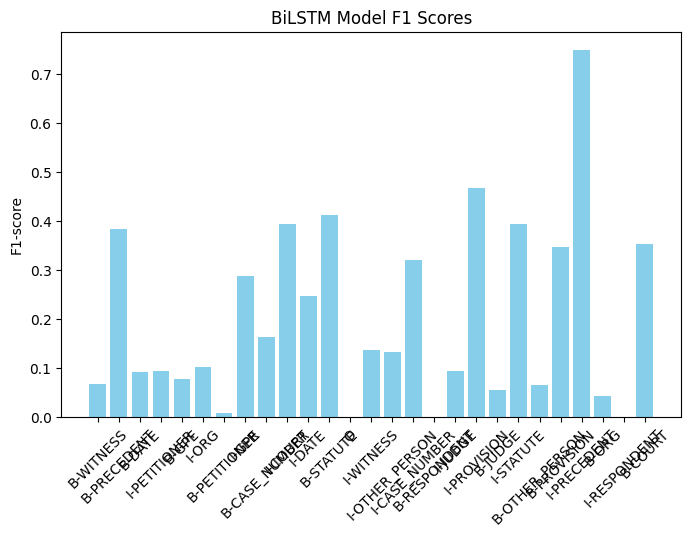

In [59]:
ml_true, ml_pred = evaluate_model(dev_tokens, dev_labels, model)
plot_f1(ml_true, ml_pred, title="BiLSTM Model F1 Scores")

Hybrid model report:


C:\Users\harsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\harsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\harsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                precision    recall  f1-score   support

 B-CASE_NUMBER      0.096     0.550     0.163       120
       B-COURT      0.219     0.924     0.354       171
        B-DATE      0.048     0.888     0.090       214
         B-GPE      0.041     0.604     0.077       164
       B-JUDGE      0.029     0.571     0.056         7
         B-ORG      0.022     0.688     0.042       144
B-OTHER_PERSON      0.035     0.553     0.065       257
  B-PETITIONER      0.004     0.111     0.007         9
   B-PRECEDENT      0.256     0.771     0.384       166
   B-PROVISION      0.211     0.967     0.346       245
  B-RESPONDENT      0.000     0.000     0.000         2
     B-STATUTE      0.271     0.867     0.413       203
     B-WITNESS      0.035     0.647     0.067        51
 I-CASE_NUMBER      0.201     0.800     0.321       434
       I-COURT      0.252     0.896     0.394       347
        I-DATE      0.143     0.911     0.248       124
         I-GPE      0.198     0.522     0.287  

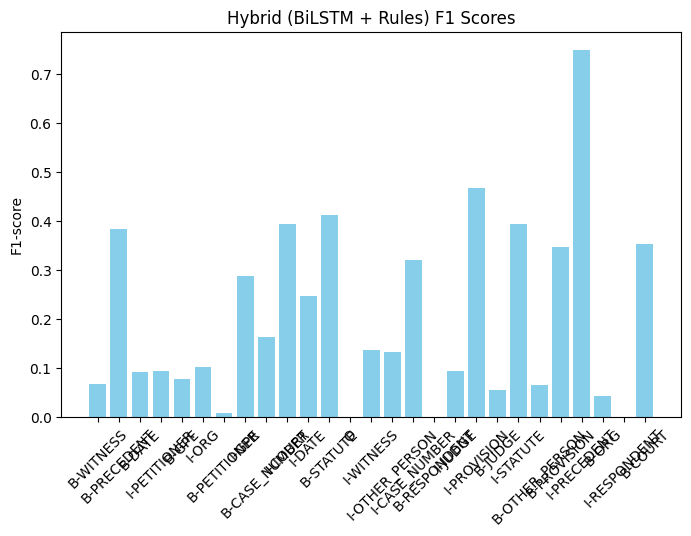

In [60]:
hy_true, hy_pred = evaluate_hybrid(dev_tokens, dev_labels, model)
plot_f1(hy_true, hy_pred, title="Hybrid (BiLSTM + Rules) F1 Scores")